In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np   
import matplotlib.pyplot as plt 

dt = 0.1

n, m = 100, 200
grid = (n, m)

chi = np.zeros((n, m, 3))

ux = np.ones((n+1, m))
uy = np.zeros((n, m+1))

edge_x = np.zeros((n+1, m))
edge_y = np.zeros((n, m+1))

def calc_C(a, b, d):
    result = 0.

    if b==0: result = d/a
    elif a==0: result = d/b
    else:
        y1 = d/b
        y2 = (d-a)/b
        x1 = d/a
        x2 = (d-b)/a

        if 0<=y1<=1:
            if 0<=y2<=1:
                result = (2-y1-y2) / 2
            elif y2<0:
                result = 1 - y1*x1/2
            elif y2>1:
                result = (1-y1)*x2/2
        elif y1<0:
            if 0<=y2<=1:
                result = 1 - (1-x1)*y2 / 2
            elif y2>1:
                result = (x1+x2) / 2
            else:
                result = 1
        elif y1>1:
            if 0<=y2<=1:
                result = (1-x2)*(1-y2)/2
            elif y2<0:
                result = 1 - (x1+x2) / 2
        if b < 0: result = 1.-result
    return result

def set_C(I, c, nx, ny):
    i, j = I
    a, b, d = -nx, ny, 0.
    if c == 1.:
        a, b, d = 1., 1., 0.
    elif c == 0.:
        a, b, d = 1., 1., 2.
    elif b == 0:
        d = a*c
    elif a == 0:
        d = b*c
    else:
        l, r = 0., 0.
        if a/b>0:
            r = 1+a/b
        else:
            l = a/b
            r = 1.
        m = (l+r)/2
        c_ = calc_C(a, b, m)
        while r-l > 1e-4:
            if c_ < c:
                r = m
            else:
                l = m
            m = (l+r)/2
            c_ = calc_C(a, b, m)
        d = m
    return a, b, d

(0.75, 0.7499923706054688)

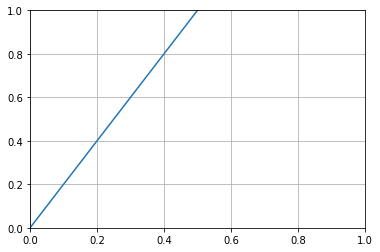

In [2]:
a, b, d = 2, -1, 0
x = np.linspace(0, 1, 100)
y = (d-a*x)/b
plt.plot(x, y)
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)

c1 = calc_C(a, b, d)
a_, b_, d_ = set_C(c1, -a, b)

c1, calc_C(a_, b_, d_)

18705.388605514294

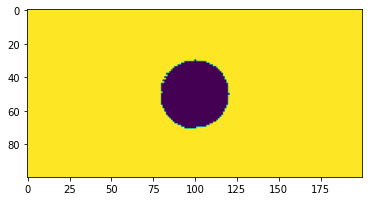

In [3]:
def bubble(i, j):
    t = np.sqrt((i - grid[0]//2)**2 + (j-grid[1]//2)**2)
    t[t<=20] = 0.
    t[t<=21] /= 21.
    t[t>21] = 1.
    return t

C = np.fromfunction(bubble, grid)
dx, dy = np.gradient(C, edge_order=2)

for i, j in np.ndindex(*grid):
    chi[i, j] = np.array(set_C(C[i, j], dx[i, j], dy[i, j]))
    a, b, d = chi[i, j]
    C[i, j] = calc_C(a, b, d)

plt.imshow(C)
C.sum()

In [4]:
def advect(I):
    i, j = I

    if C[I] == 1.:
        dC = ux[i+1, j] + uy[i, j+1]
        if C[(i-1)%100]
        C[I] -= dC*dt
    elif C[I] > 0.:
        a, b, d = chi[I]
        dC = 0.
        if a == 0:
            y = d/b if b>0 else (1-d/b)
            dC = y*(ux[i+1, j]-ux[i, j])
        elif b == 0:
            x = d/a if b>0 else (1-d/a)
            dC = x*(uy[i, j+1]-uy[i, j])
        else:
            y1 = d/b
            y2 = (d-a)/b
            x1 = d/a
            x2 = (d-b)/a
            total = ux[i+1, j]-ux[i, j] + uy[i, j+1]-uy[i, j]
            if 0<=y1<=1:
                if 0<=y2<=1:
                    dC = (1-y2)*ux[i+1, j] - (1-y1)*ux[i, j] + uy[i, j+1]
                elif y2<0:
                    dC = total - (-y1*ux[i, j]-x1*uy[i, j])
                elif y2>1:
                    dC = -(1-y1)*ux[i, j] + x2*uy[i, j+1]
            elif y1<0:
                if 0<=y2<=1:
                    dC = total - (y2*ux[i+1, j] - (1-x1)*uy[i, j])
                elif y2>1:
                    dC = x2*uy[i, j+1]-ux[i, j]-x1*uy[i, j]
                else:
                    dC = 0.
            elif y1>1:
                if 0<=y2<=1:
                    dC = (1-y2)*ux[i+1, j] + (1-x2)*uy[i, j+1]
                elif y2<0:
                    dC = total - (x2*uy[i, j+1]-x1*uy[i, j])
            if b<0: dC = total-dC

        C[I] -= dC*dt

In [5]:
def step():
    for i, j in np.ndindex(*grid):
        advect((i, j))

    dx, dy = np.gradient(C, edge_order=2)

    for i, j in np.ndindex(*grid):
        chi[i, j] = np.array(set_C(C[i, j], dx[i, j], dy[i, j]))

18663.65163319833

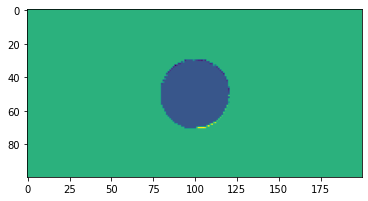

In [18]:
for _ in range(10):
    step()

plt.imshow(C)
C.sum()

In [19]:
-1 % 10

9